In [1]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ast import literal_eval

In [2]:
pd.set_option('display.max_row', 8)

In [3]:
speeches =  pd.read_csv('speeches.csv')
speeches['date'] = speeches['date'].apply(pd.to_datetime)

In [4]:
speeches['sentence_sentiment'] = speeches['sentence_sentiment'].apply(literal_eval)

In [5]:
#only want speeches longer than 10 sentences (filters out some older proclamations)
speeches = speeches[speeches['sentence_sentiment'].map(len) > 10]

In [6]:
def accumulator(vals):
    '''running sum of vector'''
    tmp = vals[:]
    for i in range(1, len(tmp)):
        try:
            if tmp[i] == 0:
                tmp[i] = tmp[i-1]
            else:
                tmp[i] = tmp[i] + tmp[i-1]
        except:
            print(tmp[i])
            print(tmp[i-1])
    return np.array([x / len(tmp) for x in tmp], dtype=float)

In [7]:
def resized(data,N):
    '''resample vector to a specified length'''    
    M = len(data)
    res = np.empty(N)
    carry = 0
    m = 0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m - (n+1) * M/N) * data[m-1]
        sum -= carry
        res[n] = sum * N/M
    return res

In [8]:
speeches['std_accumulator'] = speeches['sentence_sentiment'].apply(lambda x: resized(accumulator(x), 100))

# Sentiment Comparison

/home/charlie/anaconda2/envs/scraper/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


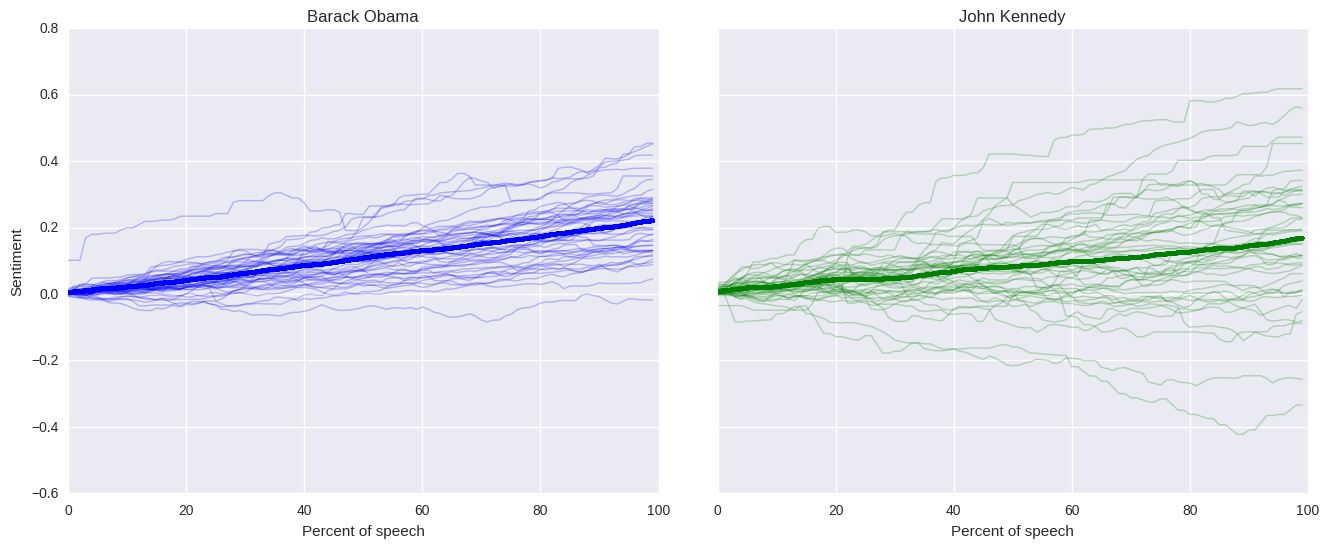

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
color_cycle = ['b', 'g', 'r', 'y']

for i, pres in enumerate(['Barack Obama', 'John Kennedy']):
    axi = ax[i]
    data = speeches[speeches['president']==pres].std_accumulator.values
    for vals in data:
        axi.plot(range(len(vals)), vals, color=color_cycle[i],lw=1, alpha=0.25)
        axi.plot(range(len(vals)), data.mean(axis=0), color=color_cycle[i], lw=3)
    axi.set_title(pres)
    axi.legend(loc='upper left')
    axi.set_xlabel('Percent of speech')
ax[0].set_ylabel('Sentiment')

plt.savefig('figs/obama_jfk.png', bbox_inches='tight')

# Sentiment Boxplot

In [10]:
pres_order = np.array(['John Kennedy', 'Lyndon Johnson', 'Richard Nixon', 'Gerald Ford',
                       'Jimmy Carter', 'Ronald Reagan', 'George H. W. Bush', 'Bill Clinton',
                       'George W. Bush', 'Barack Obama'], dtype=object)

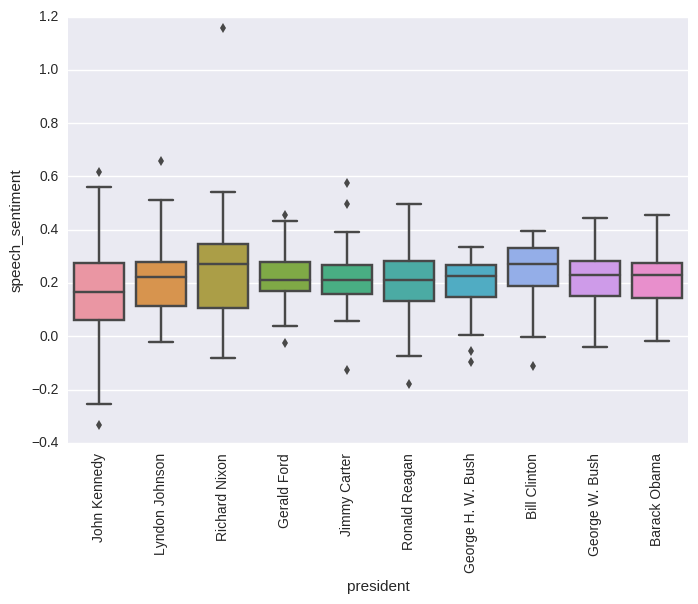

In [11]:
ax = sns.boxplot(x="president", y="speech_sentiment", data=speeches, order=pres_order)
ax.set_xticklabels(labels=pres_order, rotation=90)
plt.savefig('figs/sentiment_boxplot.png', bbox_inches='tight')

# Historical Sentiment

In [12]:
bottom_five = speeches.groupby('president').mean().sort_values('speech_sentiment')['speech_sentiment'][:5]
print(bottom_five)
#print(bottom_five.to_frame().to_html())

president
James Buchanan     0.024200
Herbert Hoover     0.088211
Andrew Johnson     0.090909
Abraham Lincoln    0.103621
Chester Arthur     0.122199
Name: speech_sentiment, dtype: float64


In [13]:
top_five = speeches.groupby('president').mean().sort_values('speech_sentiment', ascending=False)['speech_sentiment'][:5]
print(top_five)
#print(top_five.to_frame().to_html())

president
George Washington    0.444237
John Adams           0.360260
James Monroe         0.350620
John Quincy Adams    0.327188
Martin Van Buren     0.318015
Name: speech_sentiment, dtype: float64


# 2016 Presidential Candidates

In [14]:
candidates = pd.read_csv('candidates.csv')

In [15]:
candidates['sentence_sentiment'] = candidates['sentence_sentiment'].apply(literal_eval)

In [16]:
candidates['speech_sentiment'] = candidates['sentence_sentiment'].apply(lambda x: sum(x) / len(x))

In [17]:
candidates['std_accumulator'] = candidates['sentence_sentiment'].apply(lambda x: resized(accumulator(x), 100))

In [18]:
speeches = pd.concat([speeches, candidates])

In [19]:
avg_dict = {}
for pres in speeches['president'].unique():
    avg_dict[pres] = speeches[speeches['president']==pres].std_accumulator.values.mean(axis=0)

avg_sentiment = pd.DataFrame(avg_dict).T

In [20]:
from sklearn.decomposition import PCA

data = avg_sentiment.values
data_pca = PCA(2).fit_transform(data)
avg_sentiment['projection1'], avg_sentiment['projection2'] = data_pca.T

In [21]:
avg_sentiment['color'] = 0

# Nearest Neighbors

In [22]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(6).fit(avg_sentiment.iloc[:, :100])

In [23]:
dist, indices = neigh.kneighbors(avg_sentiment.iloc[:, :100][avg_sentiment.index == 'Donald Trump'])
donald = avg_sentiment.iloc[indices[0]]
avg_sentiment.loc[donald.index, 'color'] = 1
donald['distance'] = dist[0]
donald['distance']
#print(donald['distance'].to_frame().to_html())

/home/charlie/anaconda2/envs/scraper/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Donald Trump        0.000000
Chester Arthur      0.118293
Andrew Johnson      0.160548
Herbert Hoover      0.175594
William Harrison    0.199540
James Buchanan      0.297691
Name: distance, dtype: float64

In [24]:
dist, indices = neigh.kneighbors(avg_sentiment.iloc[:, :100][avg_sentiment.index == 'Hillary Clinton'])

hillary = avg_sentiment.iloc[indices[0]]
avg_sentiment.loc[hillary.index, 'color'] = 2
hillary['distance'] = dist[0]
hillary['distance']
#print(hillary['distance'].to_frame().to_html())

/home/charlie/anaconda2/envs/scraper/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Hillary Clinton      0.000000
Martin Van Buren     0.161003
John Quincy Adams    0.186880
James Monroe         0.201286
James Garfield       0.219908
Andrew Jackson       0.323196
Name: distance, dtype: float64

# Candidate Clusters

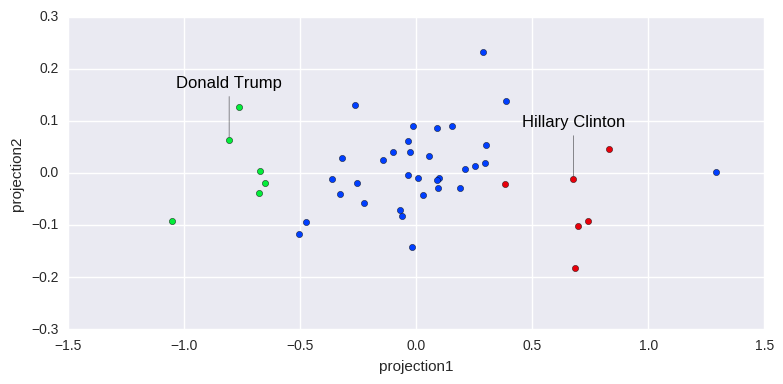

In [25]:
g = sns.FacetGrid(avg_sentiment, hue="color", palette='bright', size=4, aspect=2)
g.map(plt.scatter, "projection1", "projection2", linewidths=.3, edgecolors='black');

for i, ind in enumerate(['Hillary Clinton', 'Donald Trump']):
    x, y = avg_sentiment.loc[ind][['projection1', 'projection2']]
    ytext = y + .1
    g.ax.annotate(ind, [x, y], [x, ytext], color='black',
                  ha='center', arrowprops=dict(arrowstyle='-', color='black'))
    
plt.savefig('figs/candidate_clusters', bbox_inches='tight')

In [26]:
sentiment_order = np.concatenate((pres_order[-3:], ['Hillary Clinton', 'Donald Trump']), axis=0)

# Candidate Boxplot

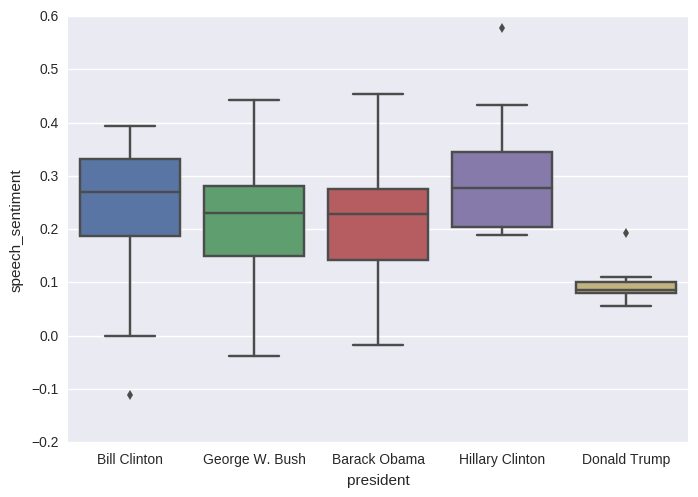

In [27]:
ax = sns.boxplot(x="president", y="speech_sentiment", data=speeches, order=sentiment_order)
ax.set_xticklabels(labels=sentiment_order, rotation=0)
plt.savefig('figs/candidate_boxplot', bbox_inches='tight')